## Facies classification using Random forest and engineered features


#### Contest entry by: <a href="https://github.com/mycarta">Matteo Niccoli</a>,  <a href="https://github.com/dahlmb">Mark Dahl</a>, with a contribution by Daniel Kittridge.

####  [Original contest notebook](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas in this notebook,</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Matteo Niccoli and Mark Dahl, </span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

### Loading the dataset with selected set of top 70 engineered features.

- We first created a large set of moments and GLCM features. The workflow is described in [this notebook]() (with huge thanks go to Daniel Kittridge for his critically needed Pandas magic, and useful suggestions). 
- We then selected 70 using a Sequential (Forward) Feature Selector form Sebastian Raschka's [mlxtend](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) library. Details in [this notebook]().


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import randint as sp_randint
from scipy.signal import argrelextrema
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import LeaveOneGroupOut, validation_curve

In [2]:
filename = 'SFS_top70_selected_engineered_features.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Depth,Facies,GR_GLCM_energy_asym_wsize=3,GR_GLCM_energy_asym_wsize=5,DeltaPHI,PHIND,NM_M,GR,GR_GLCM_correlation_asym_wsize=3,GR_mean_wsize=5,...,PE_GLCM_dissimilarity_wsize=3,PHIND_GLCM_correlation_asym_wsize=3,PE_GLCM_dissimilarity_wsize=9,PE_GLCM_dissimilarity_wsize=17,PE_GLCM_energy_wsize=3,PE_GLCM_energy_wsize=5,GR_skew_wsize=5,GR_GLCM_dissimilarity_asym_wsize=3,GR_GLCM_dissimilarity_asym_wsize=9,GR_GLCM_dissimilarity_asym_wsize=ave
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,...,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,4.503254,0.793937,0.643154,4.402484,13.201066,1.518438,64.933985,0.759942,0.000288,...,2.963606,0.759942,2.946764,2.931188,0.688497,0.577230,0.064016,2.963606,2.946764,2.906766
std,133.300164,2.474324,0.133779,0.207168,5.274947,7.132846,0.499720,30.302530,0.650069,0.914212,...,4.548968,0.650069,2.897961,2.452642,0.209758,0.251599,0.633118,4.548968,2.897961,2.365441
min,2573.500000,1.000000,0.707107,0.500000,-21.832000,0.550000,1.000000,10.149000,-1.000000,-1.726400,...,0.000000,-1.000000,0.000000,0.000000,0.500000,0.353553,-1.491707,0.000000,0.000000,0.000000
25%,2821.500000,2.000000,0.707107,0.500000,1.600000,8.500000,1.000000,44.730000,1.000000,-0.624379,...,0.000000,1.000000,0.500000,0.625000,0.500000,0.395285,-0.382517,0.000000,0.500000,1.059152
50%,2932.500000,4.000000,0.707107,0.500000,4.300000,12.020000,2.000000,64.990000,1.000000,0.009968,...,1.500000,1.000000,2.000000,2.750000,0.612372,0.433013,0.059526,1.500000,2.000000,2.643973
75%,3007.000000,6.000000,1.000000,0.790569,7.500000,16.050000,2.000000,79.438000,1.000000,0.449370,...,3.500000,1.000000,4.875000,4.625000,1.000000,0.770552,0.515196,3.500000,4.875000,4.343750
max,3138.000000,9.000000,1.000000,1.000000,19.312000,84.400000,2.000000,361.150000,1.000000,6.902566,...,32.000000,1.000000,15.000000,10.875000,1.000000,1.000000,1.493900,32.000000,15.000000,12.801339


In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five log values and two geologic constraining variables, **and we are also using depth**. We also get a vector of the facies labels that correspond to each feature vector.

In [4]:
y = training_data['Facies'].values
print y[25:40]
print np.shape(y)

[3 3 2 2 2 2 2 2 3 3 3 3 3 3 3]
(4149,)


In [5]:
X = training_data.drop(['Formation', 'Well Name','Facies'], axis=1)
print np.shape(X)
X.describe(percentiles=[.05, .25, .50, .75, .95])

(4149, 71)


,Depth,GR_GLCM_energy_asym_wsize=3,GR_GLCM_energy_asym_wsize=5,DeltaPHI,PHIND,NM_M,GR,GR_GLCM_correlation_asym_wsize=3,GR_mean_wsize=5,GR_std_wsize=5,...,PE_GLCM_dissimilarity_wsize=3,PHIND_GLCM_correlation_asym_wsize=3,PE_GLCM_dissimilarity_wsize=9,PE_GLCM_dissimilarity_wsize=17,PE_GLCM_energy_wsize=3,PE_GLCM_energy_wsize=5,GR_skew_wsize=5,GR_GLCM_dissimilarity_asym_wsize=3,GR_GLCM_dissimilarity_asym_wsize=9,GR_GLCM_dissimilarity_asym_wsize=ave
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,...,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,0.793937,0.643154,4.402484,13.201066,1.518438,64.933985,0.759942,0.000288,0.254170,...,2.963606,0.759942,2.946764,2.931188,0.688497,0.577230,0.064016,2.963606,2.946764,2.906766
std,133.300164,0.133779,0.207168,5.274947,7.132846,0.499720,30.302530,0.650069,0.914212,0.317990,...,4.548968,0.650069,2.897961,2.452642,0.209758,0.251599,0.633118,4.548968,2.897961,2.365441
min,2573.500000,0.707107,0.500000,-21.832000,0.550000,1.000000,10.149000,-1.000000,-1.726400,0.009354,...,0.000000,-1.000000,0.000000,0.000000,0.500000,0.353553,-1.491707,0.000000,0.000000,0.000000
5%,2644.200000,0.707107,0.500000,-4.000000,4.927800,1.000000,22.313200,-1.000000,-1.339196,0.036834,...,0.000000,-1.000000,0.000000,0.000000,0.500000,0.353553,-1.025811,0.000000,0.000000,0.000000
25%,2821.500000,0.707107,0.500000,1.600000,8.500000,1.000000,44.730000,1.000000,-0.624379,0.084966,...,0.000000,1.000000,0.500000,0.625000,0.500000,0.395285,-0.382517,0.000000,0.500000,1.059152
50%,2932.500000,0.707107,0.500000,4.300000,12.020000,2.000000,64.990000,1.000000,0.009968,0.156788,...,1.500000,1.000000,2.000000,2.750000,0.612372,0.433013,0.059526,1.500000,2.000000,2.643973
75%,3007.000000,1.000000,0.790569,7.500000,16.050000,2.000000,79.438000,1.000000,0.449370,0.297201,...,3.500000,1.000000,4.875000,4.625000,1.000000,0.770552,0.515196,3.500000,4.875000,4.343750
95%,3094.000000,1.000000,1.000000,12.800000,25.380000,2.000000,105.841000,1.000000,1.322431,0.750392,...,13.000000,1.000000,8.500000,7.312500,1.000000,1.000000,1.134798,13.000000,8.500000,7.320089
max,3138.000000,1.000000,1.000000,19.312000,84.400000,2.000000,361.150000,1.000000,6.902566,3.911937,...,32.000000,1.000000,15.000000,10.875000,1.000000,1.000000,1.493900,32.000000,15.000000,12.801339


### Preprocessing data with standard scaler

In [6]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

### Make F1 performance scorers

In [7]:
Fscorer = make_scorer(f1_score, average = 'micro')

### Parameter tuning ( maximum number of features and number of estimators): validation curves combined with leave one well out cross validation

In [8]:
wells = training_data["Well Name"].values
logo = LeaveOneGroupOut()

###  Random forest classifier

In Random Forest classifiers serveral decision trees (often hundreds - a forest of trees) are created and trained on a random subsets of samples (drawn with replacement) and features (drawn without replacement); the decision trees work together to make a more accurate classification (description from Randal Olson's <a href="http://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb"> excellent notebook</a>).


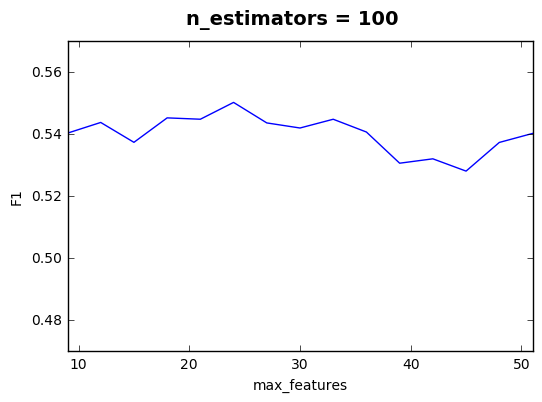

0.55030665097
24


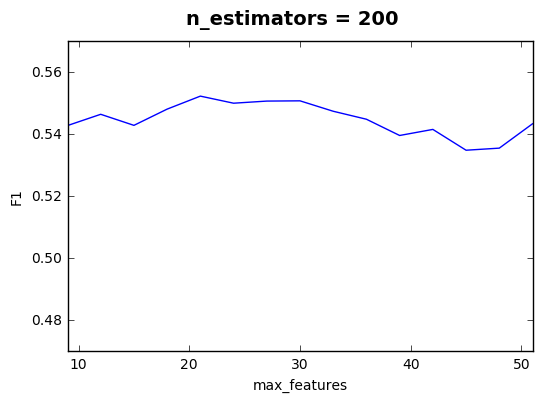

0.552334494273
21


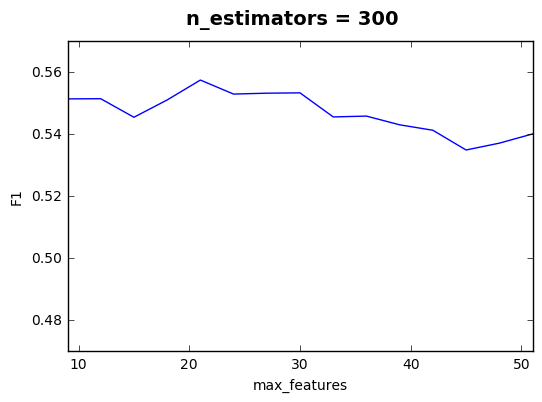

0.557514608893
21


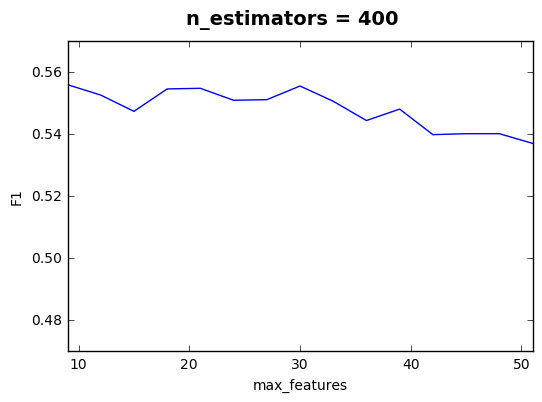

0.556026890057
9


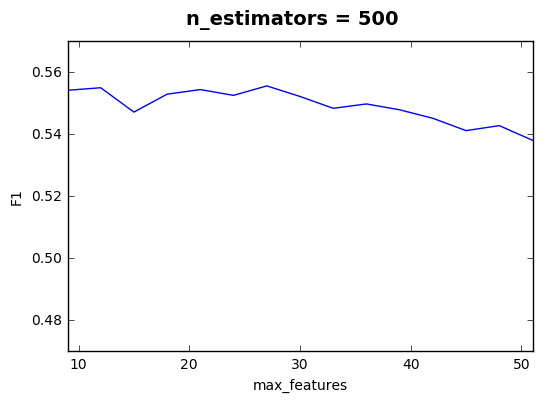

0.555633024221
27


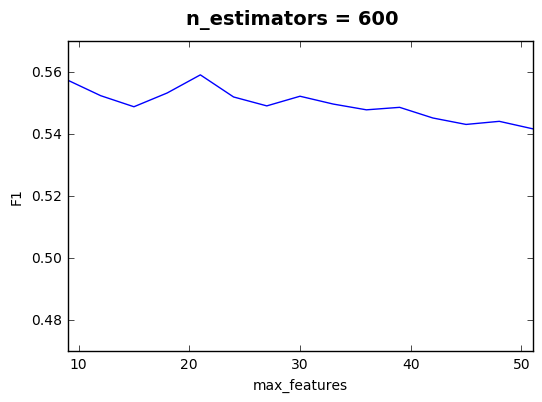

0.559193199432
21


In [9]:
from sklearn.ensemble import RandomForestClassifier
RF_clf100 = RandomForestClassifier (n_estimators=100, n_jobs=-1, random_state = 49)
RF_clf200 = RandomForestClassifier (n_estimators=200, n_jobs=-1, random_state = 49)
RF_clf300 = RandomForestClassifier (n_estimators=300, n_jobs=-1, random_state = 49)
RF_clf400 = RandomForestClassifier (n_estimators=400, n_jobs=-1, random_state = 49)
RF_clf500 = RandomForestClassifier (n_estimators=500, n_jobs=-1, random_state = 49)
RF_clf600 = RandomForestClassifier (n_estimators=600, n_jobs=-1, random_state = 49)

param_name = "max_features"
#param_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
param_range = [9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]

plt.figure()
plt.suptitle('n_estimators = 100', fontsize=14, fontweight='bold')
_, test_scores = validation_curve(RF_clf100, X, y, cv=logo.split(X, y, groups=wells),
                                  param_name=param_name, param_range=param_range,
                                  scoring=Fscorer, n_jobs=-1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores_mean)
plt.xlabel(param_name)
plt.xlim(min(param_range), max(param_range))
plt.ylabel("F1")
plt.ylim(0.47, 0.57)
plt.show()
#print max(test_scores_mean[argrelextrema(test_scores_mean, np.greater)])
print np.amax(test_scores_mean) 
print np.array(param_range)[test_scores_mean.argmax(axis=0)] 

plt.figure()
plt.suptitle('n_estimators = 200', fontsize=14, fontweight='bold')
_, test_scores = validation_curve(RF_clf200, X, y, cv=logo.split(X, y, groups=wells),
                                  param_name=param_name, param_range=param_range,
                                  scoring=Fscorer, n_jobs=-1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores_mean)
plt.xlabel(param_name)
plt.xlim(min(param_range), max(param_range))
plt.ylabel("F1")
plt.ylim(0.47, 0.57)
plt.show()
#print max(test_scores_mean[argrelextrema(test_scores_mean, np.greater)])
print np.amax(test_scores_mean) 
print np.array(param_range)[test_scores_mean.argmax(axis=0)] 

plt.figure()
plt.suptitle('n_estimators = 300', fontsize=14, fontweight='bold')
_, test_scores  = validation_curve(RF_clf300, X, y, cv=logo.split(X, y, groups=wells),
                                  param_name=param_name, param_range=param_range,
                                  scoring=Fscorer, n_jobs=-1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores_mean)
plt.xlabel(param_name)
plt.xlim(min(param_range), max(param_range))
plt.ylabel("F1")
plt.ylim(0.47, 0.57)
plt.show() 
#print max(test_scores_mean[argrelextrema(test_scores_mean, np.greater)])
print np.amax(test_scores_mean) 
print np.array(param_range)[test_scores_mean.argmax(axis=0)] 

plt.figure()
plt.suptitle('n_estimators = 400', fontsize=14, fontweight='bold')
_, test_scores  = validation_curve(RF_clf400, X, y, cv=logo.split(X, y, groups=wells),
                                  param_name=param_name, param_range=param_range,
                                  scoring=Fscorer, n_jobs=-1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores_mean)
plt.xlabel(param_name)
plt.xlim(min(param_range), max(param_range))
plt.ylabel("F1")
plt.ylim(0.47, 0.57)
plt.show()
#print max(test_scores_mean[argrelextrema(test_scores_mean, np.greater)])
print np.amax(test_scores_mean) 
print np.array(param_range)[test_scores_mean.argmax(axis=0)] 

plt.figure()
plt.suptitle('n_estimators = 500', fontsize=14, fontweight='bold')
_, test_scores  = validation_curve(RF_clf500, X, y, cv=logo.split(X, y, groups=wells),
                                  param_name=param_name, param_range=param_range,
                                  scoring=Fscorer, n_jobs=-1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores_mean)
plt.xlabel(param_name)
plt.xlim(min(param_range), max(param_range))
plt.ylabel("F1")
plt.ylim(0.47, 0.57)
plt.show()
#print max(test_scores_mean[argrelextrema(test_scores_mean, np.greater)])
print np.amax(test_scores_mean) 
print np.array(param_range)[test_scores_mean.argmax(axis=0)] 

plt.figure()
plt.suptitle('n_estimators = 600', fontsize=14, fontweight='bold')
_, test_scores  = validation_curve(RF_clf600, X, y, cv=logo.split(X, y, groups=wells),
                                  param_name=param_name, param_range=param_range,
                                  scoring=Fscorer, n_jobs=-1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(param_range, test_scores_mean)
plt.xlabel(param_name)
plt.xlim(min(param_range), max(param_range))
plt.ylabel("F1")
plt.ylim(0.47, 0.57)
plt.show()
#print max(test_scores_mean[argrelextrema(test_scores_mean, np.greater)])
print np.amax(test_scores_mean) 
print np.array(param_range)[test_scores_mean.argmax(axis=0)] 

### Average test F1 score with leave one well out

In [10]:
RF_clf_f1 = RandomForestClassifier (n_estimators=600, max_features = 21,
                                  n_jobs=-1, random_state = 49)

f1_RF = []

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    RF_clf_f1.fit(X[train], y[train])
    pred = RF_clf_f1.predict(X[test])
    sc = f1_score(y[test], pred, labels = np.arange(10), average = 'micro')
    print("{:>20s}  {:.3f}".format(well_name, sc))
    f1_RF.append(sc)
    
print "-Average leave-one-well-out F1 Score: %6f" % (sum(f1_RF)/(1.0*(len(f1_RF))))

         ALEXANDER D  0.607
     CHURCHMAN BIBLE  0.515
      CROSS H CATTLE  0.397
            KIMZEY A  0.547
            LUKE G U  0.614
               NEWBY  0.477
               NOLAN  0.581
          Recruit F9  0.625
             SHANKLE  0.584
           SHRIMPLIN  0.645
-Average leave-one-well-out F1 Score: 0.559193


### Predicting and saving facies for blind wells

In [11]:
RF_clf_b = RandomForestClassifier (n_estimators=600, max_features = 21,
                                  n_jobs=-1, random_state = 49)

In [16]:
blind = pd.read_csv('engineered_features_validation_set_top70.csv') 
X_blind = np.array(blind.drop(['Formation', 'Well Name'], axis=1)) 
scaler1 = preprocessing.StandardScaler().fit(X_blind)
X_blind = scaler1.transform(X_blind) 
y_pred = RF_clf_b.fit(X, y).predict(X_blind) 
#blind['Facies'] = y_pred

In [17]:
np.save('ypred_RF_SFS_VC.npy', y_pred)